In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf

#Deep learning Libraries
from keras.preprocessing.image import load_img,img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
picture_size=48
folder_path="/kaggle/input/face-expression-recognition-dataset/images/"

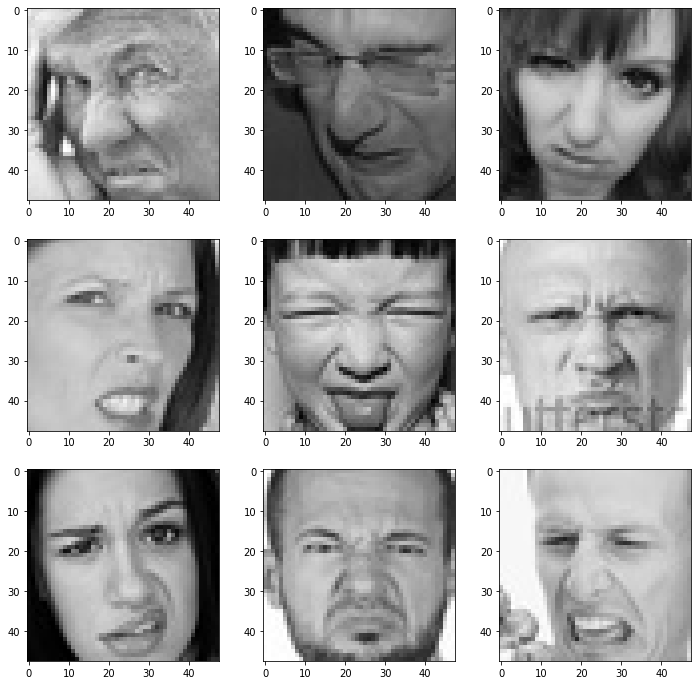

In [3]:
expression='disgust'
plt.figure(figsize=(12,12))
for i in range(1,10,1):
    plt.subplot(3,3,i)
    img=load_img(folder_path+"train/"+expression+"/"+os.listdir(folder_path+"train/"+expression)[i],target_size=(picture_size,picture_size))
    plt.imshow(img)
plt.show()    
    



In [4]:
#making training and validation data
batch_size=128
#ImageDataGenerator
# Taking this batch and applying a series of random transformations to each image in the batch (including random rotation, resizing, shearing, etc.).
# Replacing the original batch with the new, randomly transformed batch.

datagen_train=ImageDataGenerator()
datagen_val=ImageDataGenerator()

train_set=datagen_train.flow_from_directory(folder_path+"train",target_size=(picture_size,picture_size),
                                           color_mode="grayscale",batch_size=batch_size,class_mode='categorical',shuffle=True)

test_set=datagen_val.flow_from_directory(folder_path+"validation",target_size=(picture_size,picture_size),
                                           color_mode="grayscale",batch_size=batch_size,class_mode='categorical',shuffle=False)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [5]:
no_of_classes=7
model=Sequential()


#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))





opt = Adam(learning_rate = 0.0001) #lr is learning rate
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2022-12-30 17:32:43.370107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 17:32:43.371052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 17:32:43.680073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 17:32:43.680921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 17:32:43.681668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [6]:
# Fitting model with Training and Validation data
from keras.callbacks import  EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

checkpoint = ModelCheckpoint("./model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=4,
                          verbose=1,
                          restore_best_weights=True
                          ) #stopping the model if validation_accuracy keeps on decreasing
#model is not able to cop up with intialized learning rate
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=4,
                              verbose=1,
                              min_delta=0.0001)


callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 100

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])


In [7]:
history = model.fit(x=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

2022-12-30 17:32:50.051890: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-30 17:32:54.152911: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


225/225 [==============================] - 253s 1s/step - loss: 1.7939 - accuracy: 0.3077 - val_loss: 1.7261 - val_accuracy: 0.3622

Epoch 00001: val_accuracy improved from -inf to 0.36222, saving model to ./model.h5
Epoch 2/100
225/225 [==============================] - 50s 224ms/step - loss: 1.4322 - accuracy: 0.4513 - val_loss: 1.3799 - val_accuracy: 0.4784

Epoch 00002: val_accuracy improved from 0.36222 to 0.47841, saving model to ./model.h5
Epoch 3/100
225/225 [==============================] - 50s 224ms/step - loss: 1.2742 - accuracy: 0.5117 - val_loss: 1.2727 - val_accuracy: 0.5307

Epoch 00003: val_accuracy improved from 0.47841 to 0.53068, saving model to ./model.h5
Epoch 4/100
225/225 [==============================] - 50s 224ms/step - loss: 1.1886 - accuracy: 0.5477 - val_loss: 1.2746 - val_accuracy: 0.5061

Epoch 00004: val_accuracy did not improve from 0.53068
Epoch 5/100
225/225 [==============================] - 52s 229ms/step - loss: 1.1247 - accuracy: 0.5726 - val_los

<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

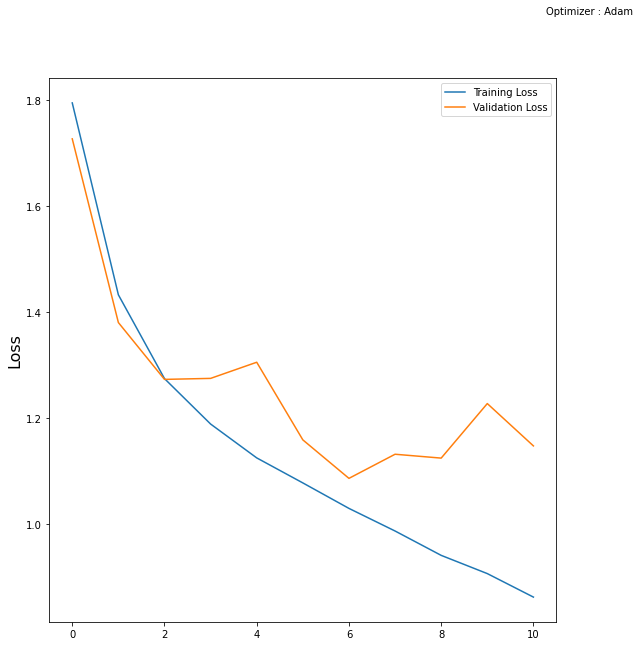

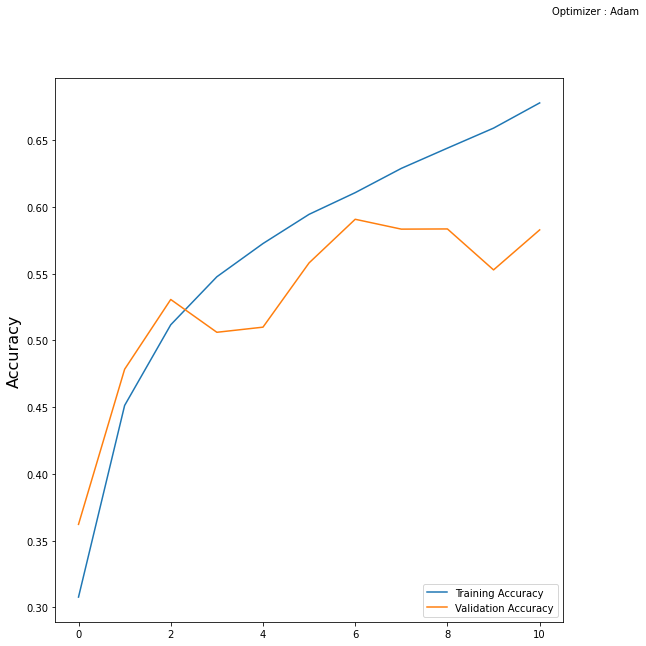

In [8]:
plt.figure(facecolor='black')
plt.figure(figsize=(20,10))

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()